faster rcnn发表于2016年，主要贡献是提出RPN网络与anchor机制用于提取候选框，极大地提升了候选框生成的速度，同时提高了候选框的质量。此外，fast RCNN与RPN共用同一特征提取网络，进一步提升推理速度。anchor机制的多anchor尺寸为网络带来尺寸不变性，效果与image pyramid与multi-view(SPPnet用的，将不同尺寸的候选框映射到特征图)。

faster RCNN的整体结构如下图（下图2为逻辑结构）,推理过程如下：原始图像经过缩放（1000x800）输入至CNNs进行特征提取，提取的特征图送入RPN进行候选框生成，生成的候选框在映射回特征图，然后经过roi pooling固定成同一尺寸，后续送入fc层，最后接一个class classifier与一个bbox regressor，分别用于分类与回归。
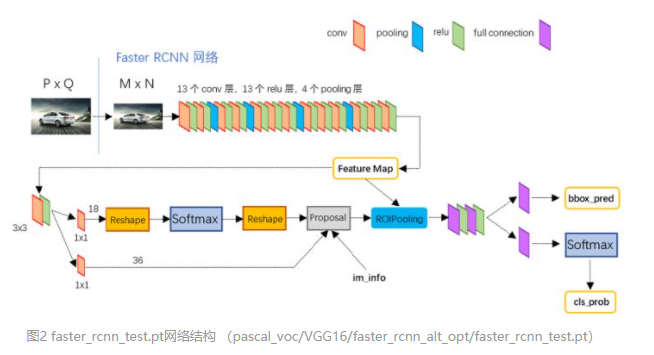

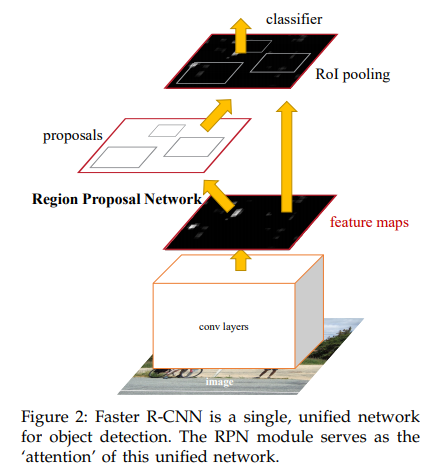

RPN(Region propasal network)如下图所示，类似于yolo中的解码操作。特征图尺寸为wxhx256，首先经过一个3x3卷积（论文中提到的sliding window，用于融合3x3感受野的特征），然后分两路，一路经过1x1卷积变为2k维（k为anchor数量，文中设为9，每个像素都有k个anchor，而每个anchor都输出一个正类与负类的score），然后经过softmax输出为正样本与负样本的概率；另一路经过1x1卷积变为4k维（每个anchor对应center_x,center_y,w,h四个坐标信息），用于生成位置信息，那么就产生了wxhxk个anchor，每个anchor有6个信息（2个score加4个坐标）。RPN原理图如下图2.
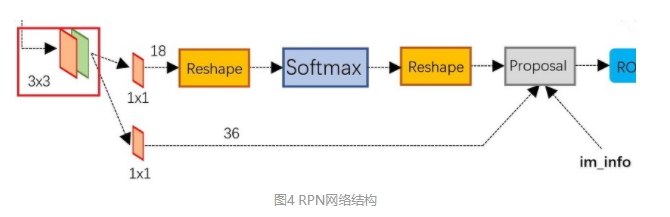

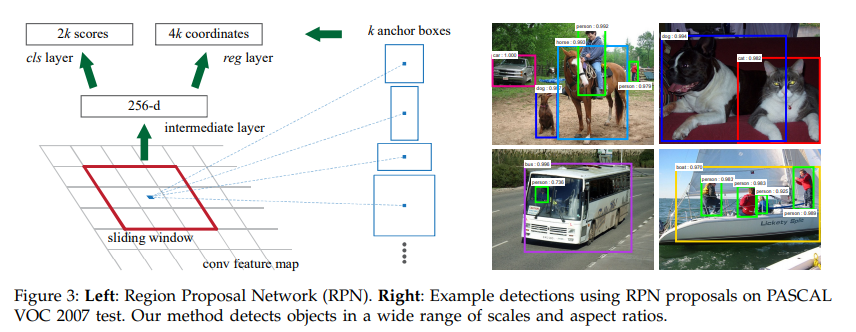

Anchors:anchor是预先设定的，经过1x1卷积后的特征图，每个像素都有几个anchor，经过RPN网络得到cls_score与坐标偏移量后，对anchor进行解码，得到最终的多个候选区域。anchors是可调节的，作者在实验中选用9个anchor，分别对应3种尺寸（128x128，256x256,512x512），3种长宽比(1:1,1:2,2:1)。如下图所示：
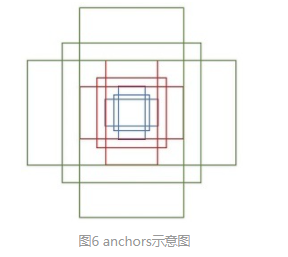

模型的训练有两种方式：<br/>
1.（分阶段训练）4-step alternating training.这种方式描述如下：<br/>
1)用imagenet训练的模型初始化特征提取网络，然后训练RPN。训练PRN时，事先标定anchor的类别（正负样本），对于一张图片，随机选择256个anchor计算loss,正负比例1:1。两种情况的anchor标记为正样本：一是与某个gt的iou最大的anchor，二是与某个gt的iou值大于0.7的anchor。而与所有gt的iou小于0.3的标记为负样本。除正样本与负样本之外的anchor忽略，不参与loss计算。RPN的loss如下：
$$
L = \frac{1}{N_{cls}}\sum_{i}{L_{cls}(p_i, p_i^*)} + \lambda \frac{1}{N_{reg}}\sum_{i}{p_i^*L_{reg}(t_i, t_i^*)}
$$
$其中，N_{cls}为mini-batch size(i.e.256,文章是从一张图像中随机采样256个anchor，一半正\\一半负，如果正的不够，用负的补足)，N_{reg}为anchor位置数量，即特征提取网络生成的特\\征图的尺寸，每个像素都要生成anchor，对于一张1000x800的输入图像，特征图尺寸为\\60x40，所以大约有2400个位置。p_i^*L_{reg}表示只有正样本才计算reg loss。\lambda为平\\衡系数，作者将\lambda设为10，使得cls项的loss与reg项的loss平等地优化（一个mini-batch\\的cls项的loss大概等于reg项loss的10倍）$<br/>
2)用imagenet训练的模型初始化特征提取网络，利用RPN提取的候选区域，训练fast RCNN。该阶段两个模型不共享特征提取层<br/>
3)用2)训练完的网络初始化特征提取层并冻结，再次训练RPN<br/>
4)冻结特征提取层与RPN层，再次训练fast RCNN的detector<br/>
注：之所以只迭代两次，是因为作者发现，再迭代下去对于性能没有影响

2.Approximate joint training(联合训练)。将RPN与fast RCNN合并成一个网络进行联合训练，训练时将RPN的loss与最终的loss求和，并做梯度反传<br/>
具体实现如下(代码中实现的方式)：<br/>
1)首先batch_szie张图像输入到网络，resize成最短边为800，然后提取特征图<br/>
2)提取的特征图输出RPN，RPN对每一张图片采样出2000(经过NMS后取前2000个score最高的)个roi备用，以输入后续网络;另一方面，RPN采样出PRN_batch_size（256)个roi区域，其中一半正，一半负（大于0.7为正,小于0.3为负），然后计算loss(cls loss与regression loss）<br/>
3)2000个roi采样出RCNN_batch_size个样本（其中正样本比例为0.25，负样本0.75，这儿正样本的标签为实际类别，与RPN不同,负样本的标签为背景，一般设为0类，正样本的iou阈值是大于0.5,负样本是0.1到0.5之间），然后计算loss(cls loss与regression loss)<br/>
4)最后进行梯度反传

实现细节：<br/>
1)对于超出边界的anchor，在训练时忽略（不忽略会导致训练不收敛，对于1000x600的输入，大概有60x40x9个anchor，通过忽略超出边界的，大概剩下6000个anchor）。在测试时做裁剪，裁剪为图像边界。<br/>
2)有些anchor相互重叠，因此用NMS去除冗余的候选框（基于cls score），将nms_thres设为0.7，最终每张图像大概剩下2000个anchors

实验部分：<br/>
1)更好的预训练模型带来较大的提升，作者用resnet时精度最高<br/>
2)更多的数据有利于训练，作者用在coco上训练的模型去评估voc，结果比在voc上训练的效果还好<br/>
3)网络对$\lambda$参数不敏感，对anchor的尺寸较敏感

代码bug记录：<br/>
代码地址：https://github.com/jwyang/faster-rcnn.pytorch/tree/pytorch-1.0<br/>
训练faster-RCNN的代码时，想要一个validation loss，于是将dataset的training改为True，
将模型中if self.training的地方改为if True，于是出现了结果接近于0的问题。<br/>
原因：训练与测试数据处理不一样，训练数据先做了crop，然后做了padding（具体原因有待进一步探究）<br/>
解决：将dataset的training改为False，测试时将模型设为model.eval()（此时集成nn.module类的模型类的self.training会变为False）, 将模型中if self.training的地方改为if True，然后在roibatchloader.py中加入validation的标签即可。